<a href="https://colab.research.google.com/github/CyberPsyLen/classifiers/blob/main/flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

In [3]:
# Connect to GDrive
from google.colab import drive
drive.mount('/content/drive')

# locate dataset
# contains subdirs: sunflower/rose/hydranger
data_path = '/content/drive/MyDrive/ML Projects/Flower Classifier/dataset'
data_dir = pathlib.Path(data_path)

print(data_dir)

Mounted at /content/drive
/content/drive/MyDrive/ML Projects/Flower Classifier/dataset


In [4]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

2435


Here are some roses:

There are this many rose images: 779
here is a random one:


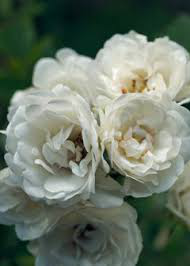

In [5]:
import random
rose_cnt = len(list(data_dir.glob('rose/*.jpeg')))
print('There are this many rose images:', rose_cnt)
print('here is a random one:')
rand_ix = random.randint(0, rose_cnt)
roses = list(data_dir.glob('rose/*'))
PIL.Image.open(str(roses[rand_ix]))

There are this many sunflowers: 669
here is a random one:


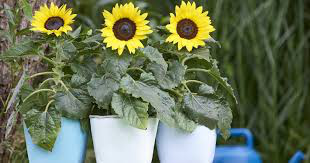

In [6]:
sunflower_cnt = len(list(data_dir.glob('sunflower/*.jpeg')))
print('There are this many sunflowers:', sunflower_cnt)
print('here is a random one:')
rand_ix = random.randint(0, sunflower_cnt)
sunflowers = list(data_dir.glob('sunflower/*'))
PIL.Image.open(str(sunflowers[rand_ix]))

There are this many hydrangers: 987
here is a random one:


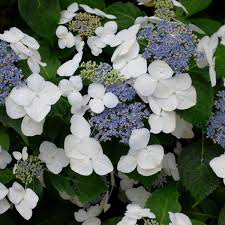

In [7]:
hydranger_cnt = len(list(data_dir.glob('hydranger/*.jpeg')))
print('There are this many hydrangers:', hydranger_cnt)
print('here is a random one:')
rand_ix = random.randint(0, hydranger_cnt)
hydrangers = list(data_dir.glob('hydranger/*'))
PIL.Image.open(str(hydrangers[rand_ix]))

# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

## Create a dataset

Define some parameters for the loader:

In [8]:
# define loader params
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [9]:
# training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2472 files belonging to 3 classes.
Using 1978 files for training.


In [10]:
# validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2472 files belonging to 3 classes.
Using 494 files for validation.


In [11]:
# verify class names
class_names = train_ds.class_names
print(class_names)

['hydranger', 'rose', 'sunflower']


## Visualize the data

Here are the first nine images from the training dataset:

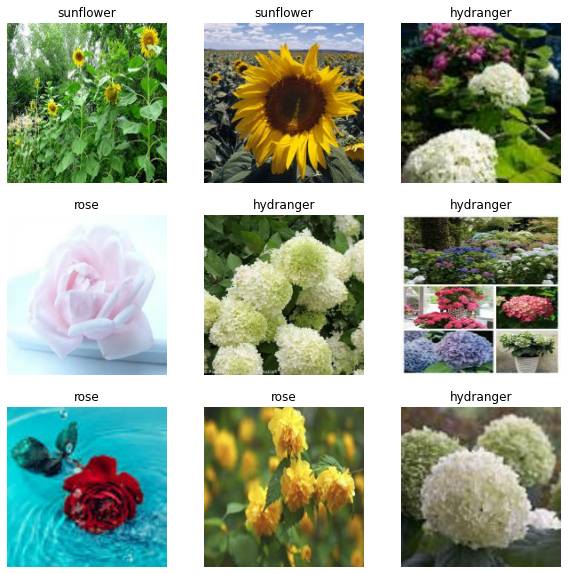

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
# check shape of data
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [15]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [16]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image)) 

Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

In [17]:
num_classes = len(class_names)

# Create the model

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

## Model summary

View all the layers of the network using the model's `Model.summary` method:

## Train the model

## Overfitting

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

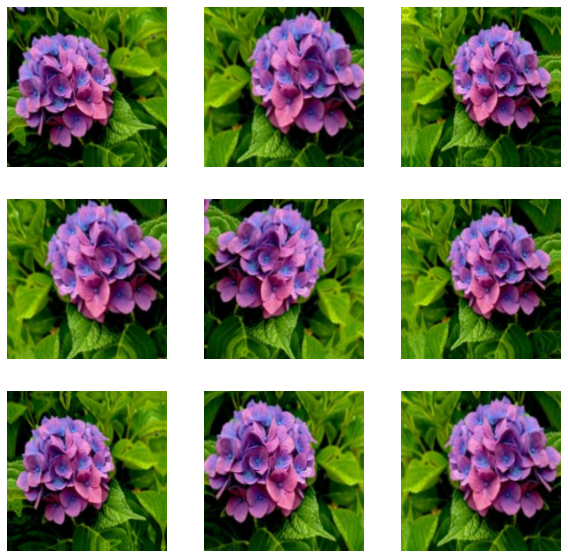

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [20]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [39]:
epochs = 150
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/150
62/62 [==============================] - 2s 34ms/step - loss: 0.3003 - accuracy: 0.8857 - val_loss: 0.4147 - val_accuracy: 0.8441
Epoch 2/150
62/62 [==============================] - 2s 33ms/step - loss: 0.2821 - accuracy: 0.8888 - val_loss: 0.4729 - val_accuracy: 0.8198
Epoch 3/150
62/62 [==============================] - 2s 27ms/step - loss: 0.2548 - accuracy: 0.9039 - val_loss: 0.4109 - val_accuracy: 0.8482
Epoch 4/150
62/62 [==============================] - 2s 27ms/step - loss: 0.2569 - accuracy: 0.9004 - val_loss: 0.4913 - val_accuracy: 0.8259
Epoch 5/150
62/62 [==============================] - 2s 27ms/step - loss: 0.2585 - accuracy: 0.8959 - val_loss: 0.4277 - val_accuracy: 0.8482
Epoch 6/150
62/62 [==============================] - 2s 27ms/step - loss: 0.2956 - accuracy: 0.8852 - val_loss: 0.3779 - val_accuracy: 0.8462
Epoch 7/150
62/62 [==============================] - 2s 27ms/step - loss: 0.2455 - accuracy: 0.9024 - val_loss: 0.4040 - val_accuracy: 0.8441
Epoch 

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

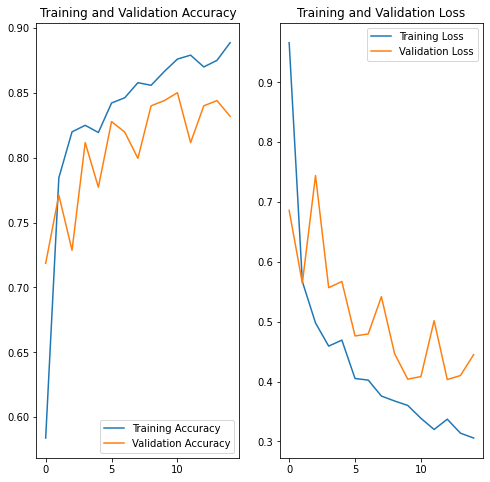

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [37]:
# flower_url = "https://images.photowall.com/products/64377/rose-flower.jpg"
flower_url = "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/skyscraper-sunflower-types-1586794555.jpg"
flower_path = tf.keras.utils.get_file('flower', origin=flower_url)

img = tf.keras.utils.load_img(flower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(predictions)
print(score)
print(class_names)


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

[[-4.9876113  2.9008482 -0.425391 ]]
tf.Tensor([3.6190863e-04 9.6496868e-01 3.4669369e-02], shape=(3,), dtype=float32)
['hydranger', 'rose', 'sunflower']
This image most likely belongs to rose with a 96.50 percent confidence.
